# SUPERVISED REGRESSION MODELLING: EXPOSURE AT DEFAULT

The objective of this model is to predict the percentage of the loan that a given borrower has not yet repaid when a default occurs:

\begin{equation*}
\text{target}_{\text{ead}} = \dfrac{\text{Amount to be paid}}{\text{Loan amount}} = \dfrac{\text{Loan amount} - \text{Amortised amount}}{\text{Loan amount}}
\end{equation*}

## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

#Autocompletar rápido
%config IPCompleter.greedy=True

#Desactivar los warnings
import warnings
warnings.filterwarnings("ignore")

## DATA IMPORTATION

Project path.

In [2]:
project_path = '../..'

Names of data files.

In [3]:
df_name = 'df_input_ead.pickle'

Data importation.

In [4]:
df = pd.read_pickle(project_path + '/02_Data/03_Work/' + df_name)

## MODELLING

In this section different combinations of algorithms/hyperparameters will be tested to find those with the best performance.

### Reserving validation dataset

In [5]:
x = df.drop(columns='target_ead')
y = df.target_ead.copy()

In [6]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Creating the pipe and the dictionary of algorithms, parameters and values to be tested

In [7]:
pipe = Pipeline([('algoritmo',Ridge())])

grid = [      
        {'algoritmo': [Ridge()],
         'algoritmo__alpha': np.arange(0.1,1.1,0.1)},
        
        {'algoritmo': [Lasso()],
         'algoritmo__alpha': np.arange(0.1,1.1,0.1)},
    
        {'algoritmo': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_error')],
         'algoritmo__learning_rate': [0.01,0.025,0.05,0.1],
         'algoritmo__max_iter': [50,100,200],
         'algoritmo__max_depth': [5,10,20],
         'algoritmo__l2_regularization': np.arange(0,1.25,0.25)}
       ]

### Hyperparameter optimization

#### Using grid search

In [8]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 3,
                           n_jobs = -1)

model = grid_search.fit(train_x.values,train_y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [9]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__alpha,param_algoritmo__l2_regularization,param_algoritmo__learning_rate,param_algoritmo__max_depth,param_algoritmo__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
52,65.924226,0.240389,1.454189,0.078629,"HistGradientBoostingRegressor(max_depth=10, ma...",NaN,0.0,0.1,10,200,{'algoritmo': HistGradientBoostingRegressor(ma...,-0.233332,-0.240378,-0.235311,-0.236340,0.002967,1
91,66.868591,0.902944,1.516827,0.108306,"HistGradientBoostingRegressor(max_depth=10, ma...",NaN,0.25,0.1,20,200,{'algoritmo': HistGradientBoostingRegressor(ma...,-0.233457,-0.237571,-0.238169,-0.236399,0.002095,2
127,66.581199,0.444227,1.499041,0.033614,"HistGradientBoostingRegressor(max_depth=10, ma...",NaN,0.5,0.1,20,200,{'algoritmo': HistGradientBoostingRegressor(ma...,-0.232111,-0.239031,-0.238370,-0.236504,0.003118,3
88,63.991437,1.193546,1.476026,0.092564,"HistGradientBoostingRegressor(max_depth=10, ma...",NaN,0.25,0.1,10,200,{'algoritmo': HistGradientBoostingRegressor(ma...,-0.236937,-0.239672,-0.233154,-0.236587,0.002672,4
160,64.855688,0.400628,1.453707,0.041893,"HistGradientBoostingRegressor(max_depth=10, ma...",NaN,0.75,0.1,10,200,{'algoritmo': HistGradientBoostingRegressor(ma...,-0.235847,-0.236030,-0.237984,-0.236620,0.000967,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0.311397,0.025757,0.007979,0.000814,Lasso(),0.8,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 0.8}",-0.343246,-0.344775,-0.344405,-0.344142,0.000651,191
18,0.369883,0.021240,0.009974,0.000815,Lasso(),0.9,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 0.9}",-0.343246,-0.344775,-0.344405,-0.344142,0.000651,191
19,0.380980,0.010587,0.039893,0.014948,Lasso(),1.0,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 1.0}",-0.343246,-0.344775,-0.344405,-0.344142,0.000651,191
14,0.295714,0.039187,0.013298,0.011056,Lasso(),0.5,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 0.5}",-0.343246,-0.344775,-0.344405,-0.344142,0.000651,191


LightGBM architecture is the one that is performing best.

Note that scores obtained in the tested algorithms/parametrisations remains stable during cross-validation process, which is a good indicator of the stability of the model predictions.

In [15]:
lgbm = HistGradientBoostingRegressor(learning_rate = 0.1,
                                     max_iter = 200,
                                     max_depth = 10,
                                     min_samples_leaf = 100,
                                     scoring = 'neg_mean_absolute_error',
                                     l2_regularization = 0.25)
lgbm.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.25, max_depth=10,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_error')

## MODEL EVALUATION

Predicting on test dataset:

In [33]:
pred = lgbm.predict(val_x)

In [27]:
print('Max:',pred.max(),'\t Min:',pred.min())

Max: 1.0990831887041046 	 Min: -0.19289025259410325


Given that the model's prediction is the percentage of the loan that a given borrower has not yet amortised when a default occurs, values must be between 0 and 1. However, the model may predict values outside this range so these cases must be corrected to avoid propagating such errors downstream.

In [45]:
pred = np.clip(pred, a_min=0, a_max=1)

In [29]:
print('Max:',pred.max(),'\t Min:',pred.min())

Max: 1.0 	 Min: 0.0


Evaluating on test dataset:

In [30]:
mean_absolute_error(val_y, pred)

0.23543829260916888

As can be seen, the error made by the model in predicting the level of not amortised loan when default occurs is high. Nevertheless, it should be noted that errors in this type of risk acquisition models are generally significantly higher than those in behavioural models, marketing, customer management, etc., as much less customer information is available when running the model.

In the same vein, it should also be noted that both defaulting and non-defaulting borrowers are being modelled, as this information is not available for a new customer. Therefore, on many occasions the model will be trying to predict the exposure at default of borrowers who are unlikely to default, which also explains the level of errors obtained in the modelling.

## MODEL REPORTING

Checking predictions:

In [49]:
check = pd.DataFrame({'ead_true':val_y, 'ead_pred':pred})

Checking the correlation between model predictions and actual values:

In [50]:
check.corr()

,ead_true,ead_pred
ead_true,1.000000,0.632616
ead_pred,0.632616,1.000000


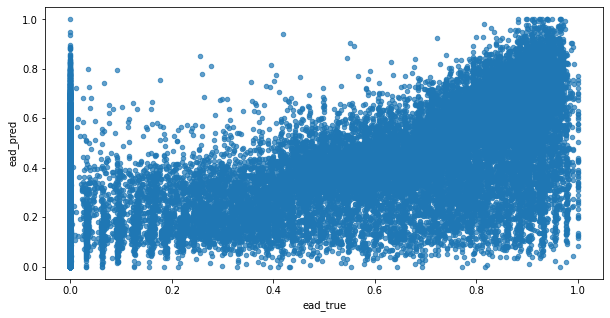

In [51]:
check.plot.scatter(x='ead_true',y='ead_pred', alpha=0.7, figsize=(10,5));

Checking the similarity between the density function of the model predictions and the actual value of the target:

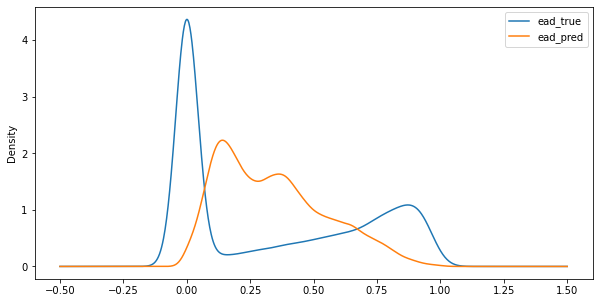

In [52]:
check.plot.density(figsize=(10,5));

It can be seen that in reality (ead_true) three large groups can be distinguished, a majority group of borrowers whose exposure to default is zero, a second group with intermediate exposures (0.25-0.75), and a last group where all those borrowers with greater exposure to default are concentrated.

Model's predictions tend towards intermediate default exposures, which leads to larger errors in predicting those borrowers with very low or very high actual default exposures.
- For customers who will actually have very limited exposures at default: the model predicts that they will have some degree at exposure to default, which will lead to somewhat higher fees/interest being charged than they would be entitled to.
- For customers with high actual default exposures: the model will tend to predict lower than actual default exposures, so that lower fees/interest will be applied than would be the case.

However, at an aggregate level from a business point of view the performance of the model is quite acceptable, as it will be covering the part of fees/interest not collected from borrowers who end up having high exposure defaults with the additional surcharges/interest charged to those customers who eventually did not have defaults, thus covering the aggregate risk of the client portfolio.